* Build BED for intron and upstream region
* intersect with fimo output from the entire genome

In [26]:
import gffutils
from gffutils import pybedtools_integration
import pybedtools
from pybedtools.featurefuncs import gff2bed
import pandas as pd
import seaborn as sb
import statsmodels 
%matplotlib inline

In [2]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [3]:
idb = gffutils.create_db(db.create_introns(), ":memory:")

In [4]:
for a in idb.featuretypes():
    print(a)

intron


In [5]:
ibed = pybedtools_integration.to_bedtool(idb.features_of_type('intron')).saveas('../../motif-wf/data/dm6_introns.bed')

Need to: 
- get exons, then merge them
- subtract from gene to get introns
- slot transcript instead of genes in step below

In [66]:
exons = pybedtools_integration.to_bedtool(db.features_of_type('exon')).saveas()

In [67]:
exonmerge = exons.merge() #need to figure this out

BEDToolsError: 
Command was:

	bedtools merge -i /tmp/pybedtools.y5_0j1yn.tmp

Error message was:
Error: Sorted input specified, but the file /tmp/pybedtools.y5_0j1yn.tmp has the following out of order record
chrX	FlyBase	exon	19963176	19963341	15	+	.	transcript_id "FBtr0307554"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RB";


In [56]:
genes = pybedtools_integration.to_bedtool(db.features_of_type('gene')).saveas()

In [57]:
slopped = genes.slop(b=1000, s=True, genome='dm6').saveas()
#pybedtools: 
#difference genes w slopped genes
#union introns w slopped
#then check with igv

In [60]:
diff = slopped.subtract(genes, s=True)

In [64]:
diff.cat(ibed, postmerge=False).saveas('../../motif-wf/data/dm6_intron_slop_nopostmerge.bed')

<BedTool(../../motif-wf/data/dm6_intron_slop_nopostmerge.bed)>

In [7]:
#read in fimo output for entire genome (dmmpmm)
#intersect with BED 
fimo = pybedtools.BedTool('../../motif-wf/data/fimo/motif_alignments_dmmpmm2009_dm6.gff')
fimo_bed = fimo.each(gff2bed, name_field='Name').saveas()

In [8]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_dmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            #TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            stuff = (start, end, pval, qval)
            table.append(stuff)
            
new_df= pd.DataFrame(table, columns=['start','end', 'pvalue', 'qvalue'])

In [9]:
dmm_df = new_df[['start','end','pvalue']]

In [10]:
fimodf = fimo_bed.to_dataframe()
fimodf.head()

,chrom,start,end,name,score,strand
0,chr2L,83873,83881,bcd,48.6,+
1,chr2L,278604,278612,bcd,48.6,+
2,chr2L,383876,383884,bcd,48.6,+
3,chr2L,405797,405805,bcd,48.6,+
4,chr2L,554219,554227,bcd,48.6,+


In [11]:
fimo_bed_df = fimodf.join(dmm_df, how='inner', rsuffix='_r')[['chrom','start','end','name', 'pvalue','strand']]

In [12]:
fimo_bed_df.to_csv('../../motif-wf/data/dmmpmm.bed', sep='\t', header=None, index=False)

In [13]:
fimo_bed_df.head()

,chrom,start,end,name,pvalue,strand
0,chr2L,83873,83881,bcd,0.000014,+
1,chr2L,278604,278612,bcd,0.000014,+
2,chr2L,383876,383884,bcd,0.000014,+
3,chr2L,405797,405805,bcd,0.000014,+
4,chr2L,554219,554227,bcd,0.000014,+


In [14]:
pfimo = pybedtools.BedTool('../../motif-wf/data/dmmpmm.bed')

In [15]:
slopped.head()

chrX	gffutils_derived	intron	19960846	19964954	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19963072	19965781	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19963945	19966005	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19964127	19966196	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19964512	19966576	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19965072	19967182	.	+	.	transcript_id "FBtr0070000"; gene_symbol "Nep3"; gene_id "FBgn0031081"; transcript_symbol "Nep3-RA";
 chrX	gffutils_derived	intron	19966013	19968080	.	+	.	transcript_id "FB

In [16]:
intersect = pfimo.intersect(slopped, wb=True).saveas()

In [17]:
very_big = intersect.to_dataframe()

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 15 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [18]:
less_big = very_big[[0,1,2,3,4,5,14]]

In [19]:
less_big.columns = ['chrom','start','end','name','pval','strand','intron_info']

In [20]:
less_big.head()

,chrom,start,end,name,pval,strand,intron_info
0,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0290323""; gene_symbol ""net""..."
1,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0330637""; gene_symbol ""net""..."
2,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""..."
3,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""..."
4,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""..."


In [21]:
less_big.intron_info[0]

'transcript_id "FBtr0290323"; gene_symbol "net"; gene_id "FBgn0002931"; transcript_symbol "net-RB";'

In [27]:
pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.1, method='fdr_bh')[1]

In [28]:
less_big_copy = less_big.copy()

In [29]:
pvals_c

array([  9.94082152e-05,   9.94082152e-05,   9.94082152e-05, ...,
         9.94082152e-05,   9.94082152e-05,   9.94082152e-05])

In [30]:
less_big_copy['qval'] = list(pvals_c)

In [31]:
less_big_copy.head()

,chrom,start,end,name,pval,strand,intron_info,qval
0,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0290323""; gene_symbol ""net""...",0.000099
1,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0330637""; gene_symbol ""net""...",0.000099
2,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099
3,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099
4,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099


In [32]:
new_df.head()

,start,end,pvalue,qvalue
0,83874,83881,0.000014,1.0
1,278605,278612,0.000014,1.0
2,383877,383884,0.000014,1.0
3,405798,405805,0.000014,1.0
4,554220,554227,0.000014,1.0


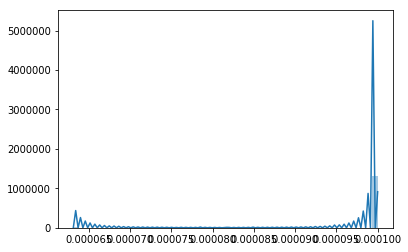

In [33]:
sb.distplot(pvals_c)

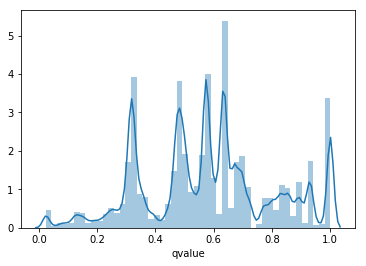

In [34]:
sb.distplot(new_df.qvalue)

In [38]:
less_big_copy

,chrom,start,end,name,pval,strand,intron_info,qval,qval2
0,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0290323""; gene_symbol ""net""...",0.000099,0.000099
1,chr2L,83873,83881,bcd,0.000014,+,"transcript_id ""FBtr0330637""; gene_symbol ""net""...",0.000099,0.000099
2,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099,0.000099
3,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099,0.000099
4,chr2L,278604,278612,bcd,0.000014,+,"transcript_id ""FBtr0078129""; gene_symbol ""smo""...",0.000099,0.000099
5,chr2L,383876,383884,bcd,0.000014,+,"transcript_id ""FBtr0078053""; gene_symbol ""al"";...",0.000099,0.000099
6,chr2L,405797,405805,bcd,0.000014,+,"transcript_id ""FBtr0078054""; gene_symbol ""RpI1...",0.000099,0.000099
7,chr2L,554219,554227,bcd,0.000014,+,"transcript_id ""FBtr0078078""; gene_symbol ""remp...",0.000099,0.000099
8,chr2L,554219,554227,bcd,0.000014,+,"transcript_id ""FBtr0303763""; gene_symbol ""remp...",0.000099,0.000099
9,chr2L,683478,683486,bcd,0.000014,+,"transcript_id ""FBtr0078045""; gene_symbol ""ds"";...",0.000099,0.000099


In [42]:
from qvalue import qvalue

In [43]:
qvalue.estimate(less_big.pval)

NameError: name 'xrange' is not defined

In [46]:
import scipy as sp
from scipy import interpolate


def estimate(pv, m=None, verbose=False, lowmem=False, pi0=None):
    """
    Estimates q-values from p-values
    Args
    =====
    m: number of tests. If not specified m = pv.size
    verbose: print verbose messages? (default False)
    lowmem: use memory-efficient in-place algorithm
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
         For most GWAS this is not necessary, since pi0 is extremely likely to be
         1
    """
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    if m is None:
        m = float(len(pv))
    else:
        # the user has supplied an m
        m *= 1.0

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = sp.arange(0, 0.90, 0.01)
        counts = sp.array([(pv > i).sum() for i in sp.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = sp.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)
        if verbose:
            print("qvalues pi0=%.3f, estimated proportion of null features " % pi0)

        if pi0 > 1:
            if verbose:
                print("got pi0 > 1 (%.3f) while estimating qvalues, setting it to 1" % pi0)
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    if lowmem:
        # low memory version, only uses 1 pv and 1 qv matrices
        qv = sp.zeros((len(pv),))
        last_pv = pv.argmax()
        qv[last_pv] = (pi0*pv[last_pv]*m)/float(m)
        pv[last_pv] = -sp.inf
        prev_qv = last_pv
        for i in range(int(len(pv))-2, -1, -1):
            cur_max = pv.argmax()
            qv_i = (pi0*m*pv[cur_max]/float(i+1))
            pv[cur_max] = -sp.inf
            qv_i1 = prev_qv
            qv[cur_max] = min(qv_i, qv_i1)
            prev_qv = qv[cur_max]

    else:
        p_ordered = sp.argsort(pv)
        pv = pv[p_ordered]
        qv = pi0 * m/len(pv) * pv
        qv[-1] = min(qv[-1], 1.0)

        for i in range(len(pv)-2, -1, -1):
            qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

        # reorder qvalues
        qv_temp = qv.copy()
        qv = sp.zeros_like(qv)
        qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv

In [53]:
qval = estimate(less_big.pval.values)

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


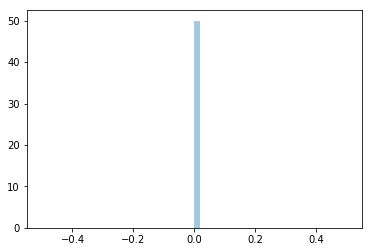

In [54]:
sb.distplot(qval)

In [55]:
set(qval)

{0.0}